#  Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1.Id
2.ProductId - unique identifier for the product
3.UserId - unqiue identifier for the user
4.ProfileName
5.HelpfulnessNumerator - number of users who found the review helpful
6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7.Score - rating between 1 and 5
8.Time - timestamp for the review
9.Summary - brief summary of the review
10.Text - text of the review
Objective:Review Polarity
Given a review, determine whether the review is positive  or negative .

# using text reviews to decide polarity

Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("database.sqlite")#Connection object that represents the database

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [14]:
print(display.shape)
display.head(10)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2
5,#oc-R12MGTQS5KZZRV,B005HG9ET0,"SKY2110 ""SKY2110""",1344211200,5,This is the highest PH level I can find withou...,3
6,#oc-R13EBF129DBX88,B007Y59HVM,mary,1344729600,2,This coffee is not what I expected. I thought...,2
7,#oc-R13NNUL4EKL4FL,B005HG9ET0,N. Chernyavskaya,1348358400,1,I tested the pH of this water. I am very disap...,3
8,#oc-R14ZSRYW2YB41B,B005HG9ET0,A. Crafton,1346284800,5,I drank this on ice after a workout. It was ve...,3
9,#oc-R15343ZW0UTLMR,B005ZBZLSU,"Lisa L. Nolen ""SimplyLisaLisa""",1346457600,1,"I shouldn't label myself a coffee connoisseur,...",2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [16]:
display['COUNT(*)'].sum()

393063

## Data cleaning

###  Data Deduplication

In [18]:
df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    393933
True     174521
dtype: int64

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Geeta gave the review at the same time for multiple product which is not possible ethically, the product were same but different flavours hence counted as multiple products

In [21]:
#Deleting all the duplicates having the same userID, Profile, NameTime and Text all in the same column.
df1 =  filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")

In [23]:
df1.shape

(4986, 10)

In [25]:
size_diff = df1['Id'].size/filtered_data['Id'].size
print("%.1f %% reduction in data after deleting duplicates"%((1-size_diff)*100))
print("Size of data",df1['Id'].size," rows ")

0.3 % reduction in data after deleting duplicates
Size of data 4986  rows 


### Helpfullness Numerator Greater than Helpfullness Denominator

In [26]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
where helpfulnessnumerator>helpfulnessdenominator
""", con)

In [28]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [29]:
df2 = df1[df1.HelpfulnessNumerator <= df1.HelpfulnessDenominator]
print("Size of data",df2['Id'].size," rows ")

Size of data 4986  rows 


In [49]:
df2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Text preprocessing

### 1.Html tag removal

In [31]:
import re 
########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
    return p.sub('',data) 

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

### 2.Punctuation removal

In [32]:
########Function to remove All the punctuations from the text
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

### 3.Stopword removal

In [34]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

### 4.Stemming

In [35]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


###  Output for 1 review

In [36]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in df2['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
['This', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'It', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'Filberts', 'And', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'And', 'it', 'is', 'a', 'tiny', 'mouthful', 'of', 'heaven', 'Not', 'too', 'chewy', 'and', 'very', 'flavorful', 'I', 'highly', 'recommend', 'this', 'yummy', 'treat', 

In [50]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in df2['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (df2['Score'].values)[i] == 1: 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(df2['Score'].values)[i] == 0:
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1

In [51]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 147667
No. of negative words: 34524

Most Common postive words [(b'not', 1826), (b'like', 1800), (b'tast', 1598), (b'good', 1538), (b'flavor', 1507), (b'love', 1460), (b'great', 1398), (b'use', 1260), (b'one', 1180), (b'product', 1165)]

Most Common negative words [(b'not', 765), (b'like', 439), (b'tast', 427), (b'product', 389), (b'tri', 277), (b'one', 274), (b'flavor', 262), (b'would', 243), (b'food', 233), (b'use', 229)]


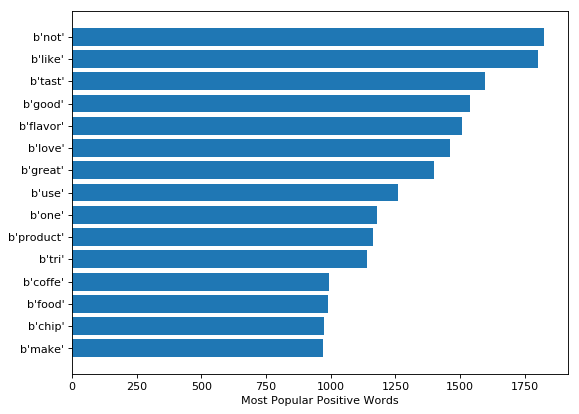

In [52]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
pos_words = positive.most_common(15)
pos_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in pos_words:
    words.append(w)
    times.append(t)
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

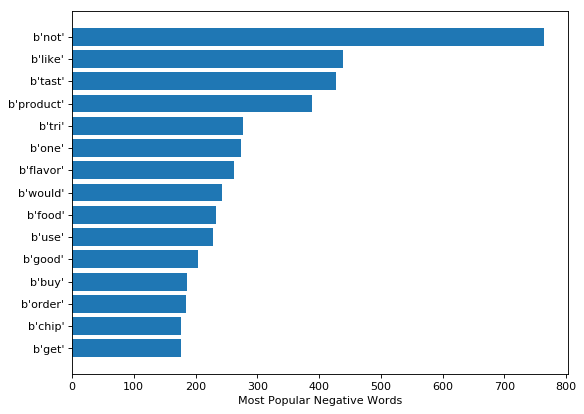

In [53]:
neg_words = negative.most_common(15)
neg_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]
for w,t in neg_words:
    words.append(w)
    times.append(t)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

In [57]:
##cleanedtextwithout stemming
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in df2['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1

In [61]:
#Adding a column of CleanedText which displays the data after pre-processing of the review 
df2['CleanedText']=final_string
df2['CleanedText_NoStem']=final_string_nostem
df2.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''


###  Unigram BOW

In [64]:
unigram = CountVectorizer() #in scikit-learn
uni_gram_vectors = unigram.fit_transform(df2['CleanedText'].values)

In [65]:
print("some feature names ", unigram.get_feature_names()[:10])

some feature names  ['aahhh', 'aback', 'abandon', 'abat', 'abbott', 'abdomin', 'abid', 'abil', 'abl', 'abor']


In [70]:
finalcount=unigram.transform(df2['CleanedText'].values)
print("the number of unique words ", finalcount.get_shape()[1])
print("the shape of out text BOW vectorizer ",finalcount.get_shape())

the number of unique words  11518
the shape of out text BOW vectorizer  (4986, 11518)


### Bigrams and Trigrams

In [71]:
countvect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = countvect.fit_transform(df2['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 2879)
the number of unique words including both unigrams and bigrams  2879


### TF-IDF

In [74]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(df2['CleanedText'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(df2['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abil', 'abl', 'abl find', 'abl get', 'absolut', 'absolut best', 'absolut delici', 'absolut love', 'absorb', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 2879)
the number of unique words including both unigrams and bigrams  2879


###  Word2Vec

In [76]:
final_string = []
for sent in df2['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [77]:
# Train your own Word2Vec model using your own text corpus
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)
#min-count: Ignoring the words which occurs less than 5 times
#size:Creating vectors of size 50 for each word

In [78]:
w2v_model.save('w2vmodel')

In [79]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [80]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

3274

In [81]:
w2v_model.wv.most_similar('like')

[('everywher', 0.49130648374557495),
 ('stick', 0.47408387064933777),
 ('insan', 0.44759052991867065),
 ('must', 0.4348951578140259),
 ('toler', 0.4274195730686188),
 ("b'say", 0.416588693857193),
 ('nut', 0.41321855783462524),
 ('grill', 0.41132351756095886),
 ('develop', 0.4083999991416931),
 ('starbuck', 0.4026731252670288)]

In [82]:
w2v_model.wv.most_similar('tast')

[('degre', 0.4646151065826416),
 ('blame', 0.43912333250045776),
 ('schedul', 0.4279276728630066),
 ('laptop', 0.41373127698898315),
 ('strict', 0.4032844305038452),
 ('smoothi', 0.4008021950721741),
 ('affect', 0.39955395460128784),
 ('matter', 0.3949795961380005),
 ('arm', 0.3938618004322052),
 ('shred', 0.39057689905166626)]

In [83]:
w2v_model.wv.most_similar('good')

[('riesl', 0.4991808533668518),
 ('babka', 0.4359245002269745),
 ('second', 0.4357939064502716),
 ('justifi', 0.4250277876853943),
 ('ranch', 0.4244123697280884),
 ('allergi', 0.4169917106628418),
 ('understood', 0.4160340428352356),
 ("b'perfect", 0.4091606140136719),
 ('gag', 0.4085771441459656),
 ('pair', 0.40440213680267334)]

# Logistic Regression

In [84]:
df_sample = df2
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...,b''
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...,b''
3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,b'mae ploy sweet chili sauc becom standard con...,b''
1112,1206,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13,14,1,1088467200,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...,b'perfect year round meat dish omaha steak twi...,b''
1176,1276,B000WNJ73Q,A394MHK3CSDGUV,kaleinor,2,2,1,1091318400,5 Woofs!,Five of my five dogs agree - they'd rather mun...,b'five five dog agre theyd rather munch liver ...,b''
1173,1273,B000WNJ73Q,A22A7OEB664QSC,Kathleen Stept,3,3,1,1092787200,"Healthy, non-fattening, just the right size an...",I've been feeding liver biscotti for years. I ...,b'ive feed liver biscotti year look healthi tr...,b''
1193,1293,B000WNJ73Q,AE5DR1HZNY9CV,Rich Wyzykoski,0,0,1,1106438400,Rich J Wyzykoski,"A fantastic product for pet treats,great smell...",b'fantast product pet treatsgreat smell liver ...,b''
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,b'dont know cactus tequila uniqu combin ingred...,b''
2489,2709,B003NDA970,A1X37RPYOJLQXS,"Linda S. Mcewen ""Linda""",13,14,1,1108771200,Tender,"I was a little concerned to buy the popcorn, a...",b'littl concern buy popcorn never know go get ...,b''
3479,3781,B00016UX0K,A3GFVNB9R3XAL8,D. Louie,0,0,1,1118707200,Put it over all meats,I love this stuff. I put it over chicken and ...,b'love stuff put chicken even steak sweet bit ...,b''


In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (3490, 9605)
Test Data Size:  (1496, 9605)


In [88]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(320, 9605) (317, 9605)
(637, 9605) (317, 9605)
(954, 9605) (317, 9605)
(1271, 9605) (317, 9605)
(1588, 9605) (317, 9605)
(1905, 9605) (317, 9605)
(2222, 9605) (317, 9605)
(2539, 9605) (317, 9605)
(2856, 9605) (317, 9605)
(3173, 9605) (317, 9605)


In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best HyperParameter:  {'C': 50, 'penalty': 'l2'}
Best Accuracy: 87.92%


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.5s finished


Accuracy on test set: 88.570%
Precision on test set: 0.905
Recall on test set: 0.961
F1-Score on test set: 0.932
Non Zero weights: 9605
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



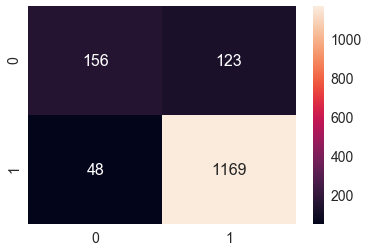

In [96]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## TF IDF

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (3490, 97098)
Test Data Size:  (1496, 97098)


In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   39.9s finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l1'}
Best Accuracy: 87.70%


Accuracy on test set: 89.840%
Precision on test set: 0.924
Recall on test set: 0.953
F1-Score on test set: 0.939
Non Zero weights: 460
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



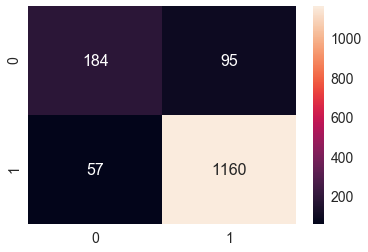

In [100]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')